In [1]:
import numpy as np
import matplotlib.pyplot as plt


import gymnasium as gym
import pygame

from typing import List
import random
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
class Environment:
    def __init__(self):
        self.steps_left = 100
        
    def get_observation(self) -> List[float]:
        return [0.0, 0.0, 0.0]
    
    def get_actions(self) -> List[int]:
        return [0, 1]
    
    def is_done(self) -> bool:
        return self.steps_left == 0
    
    def action(self, action: int) -> float:
        
        # Handles and agents action and returns the reward
        
        if self.is_done():
            raise Exception("Game is over")
        self.steps_left -= 1
        return random.random() # Reward is random in this example

In [3]:
class Agent:
    def __init__(self):
        self.total_reward = 0.0
        
    def step(self, env: Environment):
        """
        Observe the environment
        Make a decision about the action to take based on the observations
        Submit the action to the environment
        Get the reward for the current step
        """
        current_obs = env.get_observation()
        actions = env.get_actions()
        reward = env.action(random.choice(actions))
        self.total_reward += reward

In [4]:
if __name__ == "__main__":
    env = Environment()
    agent = Agent()
    
    while not env.is_done():
        agent.step(env)
        
    print("Total reward got: %.4f" % agent.total_reward)

Total reward got: 51.7890


In [5]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(state_size, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128,128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Linear(128, action_size) # Predict Q-Values for all possible actions
        )

    def forward(self, x):
        return self.nn(x)

In [6]:
# Let's initialize our environment
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Hyperparameters
batch_size = 64
gamma = 0.99           
epsilon = 1.0          
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.002
target_update_freq = 10
max_episodes = 10000

print(f"State size: {state_size}") # cart position, cart velocity, pole angle, and velocity tip of the pole.
print(f"Action size: {action_size}") # move left or move right

State size: 4
Action size: 2


In [7]:
policy_net = DQN(state_size, action_size)
target_net = DQN(state_size, action_size)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() # normal behaviour, no regularization (evaluation mode, no training)

optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()


memory = deque(maxlen=2000)


In [8]:
def remember(state, action, reward, next_state, done):
    """
    Keep different memories in buffer for sampling later.
    """
    memory.append((state, action, reward, next_state, done))

def act(state, epsilon):
    """
    Do a random action with epsilon frequency. Otherwise, do the action
    that has the maximum q_value.
    """
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    with torch.no_grad(): # Disable gradient computation. Only need prediction here, no weights. Saves memory and is faster.
        q_values = policy_net(state_tensor) # Returns each Q-Value for each action
    return int(torch.argmax(q_values, dim=1).item()) # Select the action with the highest Q-Value

def replay():
    if len(memory) < batch_size:
        return # return nothing if we do not have enough memories in the buffer to complete one batch
    
    minibatch = random.sample(memory, batch_size) # Random sample, avoid correlation 
    states, actions, rewards, next_states, dones = zip(*minibatch)
    
    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1) # Indexing in PyTorch requires the indices to be of the long type.
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    # Current Q-values for the actions taken
    q_values = policy_net(states).gather(1, actions).squeeze()

    # Next state Q-values from target network
    next_q_values = target_net(next_states).max(1)[0]
    target_q_values = rewards + gamma * next_q_values * (1 - dones)

    loss = loss_fn(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [10]:
# Training loop with early stopping condition (average reward > 400 over last 50 episodes)
episode_rewards = []

for episode in range(1, max_episodes + 1):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = act(state, epsilon)
        next_state, reward, done, truncated, _ = env.step(action)
        # Penalize if episode ends early
        reward = reward if not done else -10
        remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        
        replay()
        if done or truncated:
            break

    # Decay exploration rate
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    episode_rewards.append(total_reward)
    
    # Update target network periodically
    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Check average reward over the last 50 episodes
    if len(episode_rewards) >= 50:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode} - Total Reward: {total_reward}, Average Reward (last 50): {avg_reward:.2f}")
        if avg_reward > 400:
            print("Training finished - average reward > 400 over the last 50 episodes")
            break
    else:
        print(f"Episode {episode} - Total Reward: {total_reward}")

env.close()


Episode 1 - Total Reward: 121.0
Episode 2 - Total Reward: 116.0
Episode 3 - Total Reward: 126.0
Episode 4 - Total Reward: 102.0
Episode 5 - Total Reward: 101.0
Episode 6 - Total Reward: 102.0
Episode 7 - Total Reward: 108.0
Episode 8 - Total Reward: 105.0
Episode 9 - Total Reward: 112.0
Episode 10 - Total Reward: 100.0
Episode 11 - Total Reward: 99.0
Episode 12 - Total Reward: 117.0
Episode 13 - Total Reward: 100.0
Episode 14 - Total Reward: 111.0
Episode 15 - Total Reward: 98.0
Episode 16 - Total Reward: 102.0
Episode 17 - Total Reward: 99.0
Episode 18 - Total Reward: 107.0
Episode 19 - Total Reward: 99.0
Episode 20 - Total Reward: 96.0
Episode 21 - Total Reward: 101.0
Episode 22 - Total Reward: 101.0
Episode 23 - Total Reward: 102.0
Episode 24 - Total Reward: 86.0
Episode 25 - Total Reward: 92.0
Episode 26 - Total Reward: 101.0
Episode 27 - Total Reward: 93.0
Episode 28 - Total Reward: 92.0
Episode 29 - Total Reward: 83.0
Episode 30 - Total Reward: 91.0
Episode 31 - Total Reward: 100

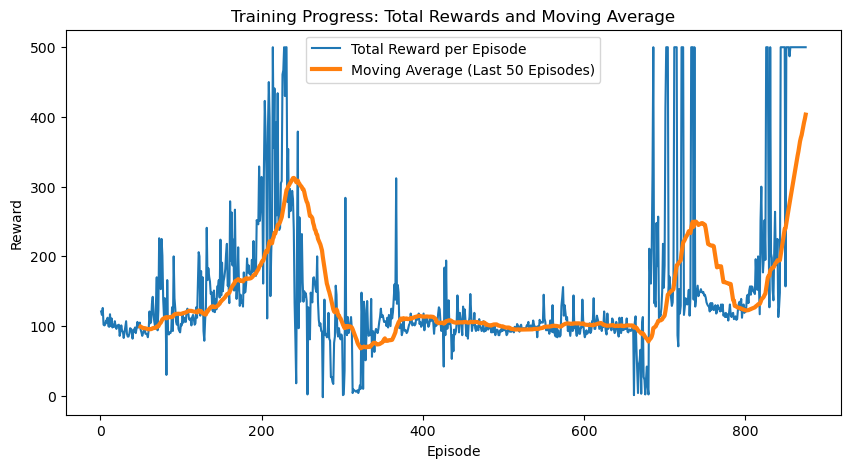

In [11]:

# Plot total rewards per episode and the moving average over the last 50 episodes
episodes = range(1, len(episode_rewards) + 1)
window = 50
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(episodes, episode_rewards, label="Total Reward per Episode")
plt.plot(range(window, len(episode_rewards) + 1), moving_avg, label="Moving Average (Last 50 Episodes)", linewidth=3)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Training Progress: Total Rewards and Moving Average")
plt.legend()
plt.show()

In [ ]:
# After training, create a new environment with rendering enabled
play_env = gym.make("CartPole-v1", render_mode="human")
state, _ = play_env.reset()
done = False
total_reward = 0

while not done:
    action = act(state, epsilon=0.0)  # Use greedy action (no exploration)
    state, reward, done, truncated, _ = play_env.step(action)
    total_reward += reward
    play_env.render()  # Display the animation frame by frame
    if done or truncated:
        break

print(f"Final run total reward: {total_reward}")

try:
    env.close()
except Exception as e:
    print("Error closing environment:", e)
    pygame.display.quit()
    pygame.quit()

### Question 1:
After this tutorial, your current goal now is to achieve a higher reward in the CartPole environment using the Deep Q-Network (DQN). Modify the training code so that the agent achieves an **average reward of 450 over the last 100 observations**. You may consider adjusting the learning rate, gamma, introducing an alpha value (see notes) or changing the architecture of the NN (Layers, Regularization, Neurons, etc). You can also experiment with changing the epsilon schedule (exploration/exploitation balance). Try and do it in the minumum number of Episodes possible (max 10,000).